In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_bw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [3]:
from src.gpu_info.gpu_info import get_gpu_info

In [4]:
get_gpu_info(0)

Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/gpu_info2/build.ninja...
Building extension module gpu_info2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gpu_info2...


{'name': 'NVIDIA GeForce RTX 4060 Laptop GPU',
 'luid': '',
 'luidDeviceNodeMask': 0,
 'totalGlobalMem': 8325824512,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'memPitch': 2147483647,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim[0]': 1024,
 'maxThreadsDim[1]': 1024,
 'maxThreadsDim[2]': 64,
 'maxGridSize[0]': 2147483647,
 'maxGridSize[1]': 65535,
 'maxGridSize[2]': 65535,
 'clockRate': 2250000,
 'totalConstMem': 65536,
 'major': 8,
 'minor': 9,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'deviceOverlap': 1,
 'multiProcessorCount': 24,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture1DMipmap': 32768,
 'maxTexture1DLinear': 268435456,
 'maxTexture2D': 131072,
 'maxTexture2DMipmap': 32768,
 'maxTexture2DLinear': 131072,
 'maxTexture2DGather': 32768,
 'maxTexture3D': 16384,
 'maxTexture3DAlt': 8192,
 'maxTextureCubemap': 32768,
 'maxTexture1DLayered': 32768,
 'maxTextu

### define inputs

In [5]:
S = 32 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 32 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_C_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [10]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)
dQs_pt_half, dKs_pt_half, dVs_pt_half, dIgs_pt_half, dFgs_pt_half, delta_C_pt_half, delta_D_pt_half, delta_Dtilde_pt_half, delta_fbar_pt_half, mat_P_pt_half, mat_R_pt_half = vlstm_bw_torch_obw(
    delta_Htilde=dHs_half,
    queries=qs_half,
    keys=ks_half,
    values=vs_half,
    igate_preact=igs_half,
    fgate_preact=fgs_half,
    var_n=n_pt_half,
    var_m=m_pt_half,
)
dQs_pt_half.dtype, delta_D_pt_half.dtype

(torch.float16, torch.float16)

In [11]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)
dQs_pt_bf16, dKs_pt_bf16, dVs_pt_bf16, dIgs_pt_bf16, dFgs_pt_bf16, delta_C_pt_bf16, delta_D_pt_bf16, delta_Dtilde_pt_bf16, delta_fbar_pt_bf16, mat_P_pt_bf16, mat_R_pt_bf16 = vlstm_bw_torch_obw(
    delta_Htilde=dHs_bf16,
    queries=qs_bf16,
    keys=ks_bf16,
    values=vs_bf16,
    igate_preact=igs_bf16,
    fgate_preact=fgs_bf16,
    var_n=n_pt_bf16,
    var_m=m_pt_bf16,
)
dQs_pt_bf16.dtype, delta_D_pt_bf16.dtype

(torch.bfloat16, torch.bfloat16)

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_half - dFgs_pt))}")
print(f"bw delta_D match: {torch.allclose(delta_D_pt_half.float(), delta_D_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(delta_D_pt_half - delta_D_pt))}")
print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_bf16 - dFgs_pt))}")


====== Full -> Half ======
fw hs match: False, max diff: 0.03671121597290039
fw n match: False, max diff: 0.010063886642456055
fw m match: False, max diff: 0.007931828498840332
fw D match: False, max diff: 0.002885758876800537
---------------------------------
bw dQs match: False, max diff: 0.07791519165039062
bw dKs match: False, max diff: 0.055771589279174805
bw dVs match: False, max diff: 0.03298354148864746
bw dIgs match: False, max diff: 0.09398460388183594
bw dFgs match: False, max diff: 0.03934335708618164
bw delta_D match: False, max diff: 0.30063629150390625
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.7851881980895996
fw n match: False, max diff: 0.058682143688201904
fw m match: False, max diff: 0.07787561416625977
fw D match: False, max diff: 0.11114472150802612
---------------------------------
bw dQs match: False, max diff: 0.7875323295593262
bw dKs match: False, max diff: 0.669497013092041
bw dVs match: False, max diff: 0.6766901016235352
bw dIgs match: 

In [13]:
(matD_pt)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1548e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3850e-01, 1.2679e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 8.0032e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4947e-02, 3.1993e-02, 2.5233e-01, 6.2876e-01, 5.0321e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.2326e-03, 2.9594e-03, 2.3340e-02, 5.8161e-02, 4.6547e-02, 9.2500e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2185e-03, 1.1155e-03, 8.7981e-03, 2.1923e-02, 1.7546e-02, 3.486

In [14]:
(matD_pt_half)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1504e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3855e-01, 1.2683e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5542e-02, 5.0873e-02, 4.0137e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5664e-02, 5.0873e-02, 4.0137e-01, 1.0000e+00, 7.9932e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.5034e-02, 3.2013e-02, 2.5293e-01, 6.3086e-01, 5.0391e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.2330e-03, 2.9545e-03, 2.3376e-02, 5.8441e-02, 4.6600e-02, 9.2468e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2178e-03, 1.1177e-03, 8.8196e-03, 2.1881e-02, 1.7471e-02, 3.476

In [15]:
(matD_pt_bf16)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1016e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3965e-01, 1.2695e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 4.0039e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 3.9844e-01, 1.0000e+00, 7.9688e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4180e-02, 3.2227e-02, 2.5000e-01, 6.2891e-01, 4.9805e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.0823e-03, 2.8076e-03, 2.3193e-02, 5.8105e-02, 4.6143e-02, 9.1797e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2054e-03, 1.0986e-03, 8.9111e-03, 2.2095e-02, 1.7700e-02, 3.540

In [16]:
(matD_pt_half - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -4.3637e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 5.0411e-05,  3.8266e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.8959e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.3111e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00, -1.0080e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.6937e-05,  1.9595e-05,  6.0183e-04,  2.0962e-03,  6.9177e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 3.3574e-07, -4.9016e-06,  3.6132e-05,  2.8056e-04,  5.2996e-05, -3.1762e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [17]:
(matD_pt_bf16 - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.3192e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.1490e-03,  1.6034e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -9.1767e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -2.8708e-03,  0.0000e+00, -3.4494e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-7.6756e-04,  2.3322e-04, -2.3279e-03,  1.4311e-04, -5.1676e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.5034e-04, -1.5177e-04, -1.4697e-04, -5.5138e-05, -4.0477e-04, -7.0315e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [18]:
# (hs_pt_half.float() - hs_pt) #> 4.5e-3

In [19]:
# (hs_pt_bf16.float() - hs_pt) #> 0.018

In [20]:
torch.abs(hs_pt_bf16.float() - hs_pt).max(), torch.abs(hs_pt_bf16.float() - hs_pt).mean() #> 1e-2

(tensor(0.7852, device='cuda:0'), tensor(0.0268, device='cuda:0'))

### match directly

In [21]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 28096
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 16, KVtileDim: 16, TblockDim:4
BIdx(0,0),TIdx(0,0),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,0), : dC=3.660282,Dstr=1.000000,S=0.003233 - P=3.660282,R=0.003233
BIdx(0,0),TIdx(0,1),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,1), : dC=0.288379,Dstr=1.000000,S=0.001219 - P=0.288379,R=0.001219
BIdx(0,0),TIdx(0,2),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,2), : dC=-3.492333,Dstr=0.138499,S=0.001219 - P=-0.483686,R=0.000169
BIdx(0,0),TIdx(0,3),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,3), : dC=-1.816332,Dstr=0.055581,S=0.000110 - P=-0.100953,R=0.000006
BIdx(0,0),T

In [22]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)
dQs_cu_half, dKs_cu_half, dVs_cu_half, dIgs_cu_half, dFgs_cu_half, matC_cu_half = vlstm_bw_cuda(
    mat_delta_H=dHs_half,
    mat_Q=qs_half,
    mat_K=ks_half,
    mat_V=vs_half,
    vec_igp=igs_half,
    vec_fgp=fgs_half,
    vec_n=n_cu_half,
    vec_m=m_cu_half,
)

before kernel dispatch - float16!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 21120
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - float16!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 14336
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 16, KVtileDim: 16, TblockDim:4
BIdx(0,0),TIdx(0,0),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,0), : dC=3.660156,Dstr=1.000000,S=0.003233 - P=3.660156,R=0.003233
BIdx(0,0),TIdx(0,1),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,1), : dC=0.289062,Dstr=1.000000,S=0.001223 - P=0.289062,R=0.001223
BIdx(0,0),TIdx(0,2),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,2), : dC=-3.494141,Dstr=0.138672,S=0.001223 - P=-0.484619,R=0.000170
BIdx(0,0),TIdx(0,3),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,3), : dC=-1.818359,Dstr=0.055664,S=0.000111 - P=-0.101196,R=0.000006
BIdx(0,0),T

In [23]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)
dQs_cu_bf16, dKs_cu_bf16, dVs_cu_bf16, dIgs_cu_bf16, dFgs_cu_bf16, matC_cu_bf16 = vlstm_bw_cuda(
    mat_delta_H=dHs_bf16,
    mat_Q=qs_bf16,
    mat_K=ks_bf16,
    mat_V=vs_bf16,
    vec_igp=igs_bf16,
    vec_fgp=fgs_bf16,
    vec_n=n_cu_bf16,
    vec_m=m_cu_bf16,
)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 21120
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 14336
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 16, KVtileDim: 16, TblockDim:4
BIdx(0,0),TIdx(0,0),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,0), : dC=3.671875,Dstr=1.000000,S=0.003189 - P=3.671875,R=0.003189
BIdx(0,0),TIdx(0,1),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,1), : dC=0.292969,Dstr=1.000000,S=0.001244 - P=0.292969,R=0.001244
BIdx(0,0),TIdx(0,2),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,2), : dC=-3.484375,Dstr=0.138672,S=0.001244 - P=-0.482422,R=0.000173
BIdx(0,0),TIdx(0,3),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,3), : dC=-1.843750,Dstr=0.055420,S=0.000109 - P=-0.102051,R=0.000006
BIdx(0,0)

In [24]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_half - dFgs_pt))}")
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_bf16 - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: True, max diff: 3.6716461181640625e-05
fw n match: True, max diff: 5.7220458984375e-06
fw m match: True, max diff: 3.5762786865234375e-06
fw D match: True, max diff: 1.430511474609375e-06
---------------------------------
bw dQs match: False, max diff: 154.60035705566406
bw dKs match: False, max diff: 164.1123046875
bw dVs match: False, max diff: 156.4673614501953
bw dIgs match: True, max diff: 0.00012230873107910156
bw dFgs match: True, max diff: 2.5272369384765625e-05
====== Half ======
fw hs match: False, max diff: 0.012780904769897461
fw n match: False, max diff: 0.00409388542175293
fw m match: False, max diff: 0.0012853145599365234
fw D match: False, max diff: 0.011081695556640625
---------------------------------
bw dQs match: False, max diff: 154.19850158691406
bw dKs match: False, max diff: 163.72833251953125
bw dVs match: False, max diff: 156.0692596435547
bw dIgs match: False, max diff: 0.03148460388183594
bw dFgs matc

In [25]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

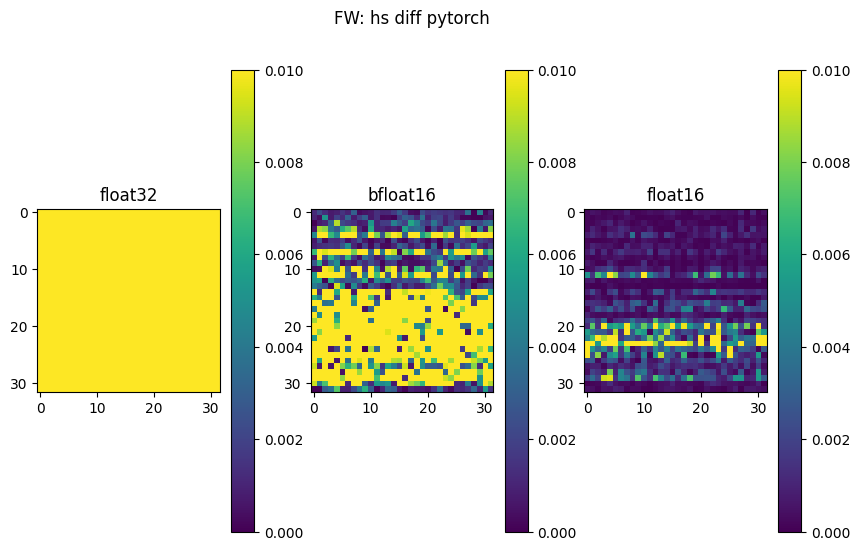

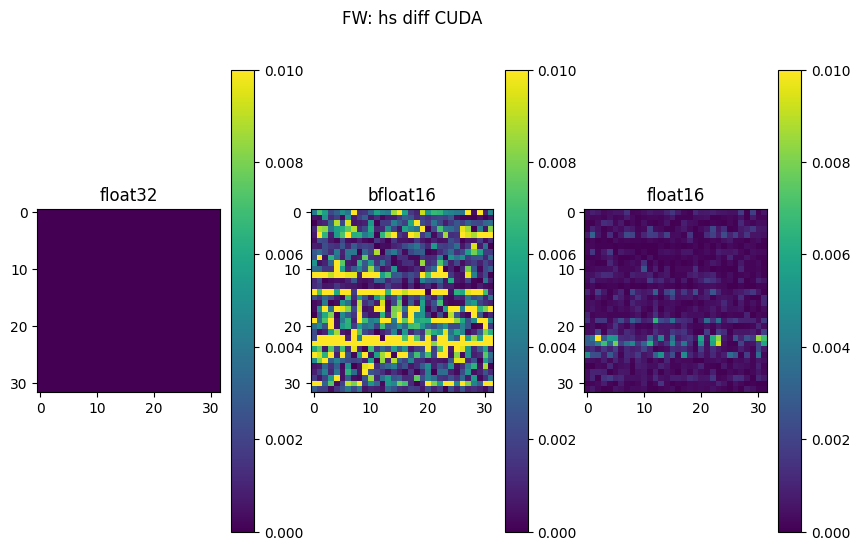

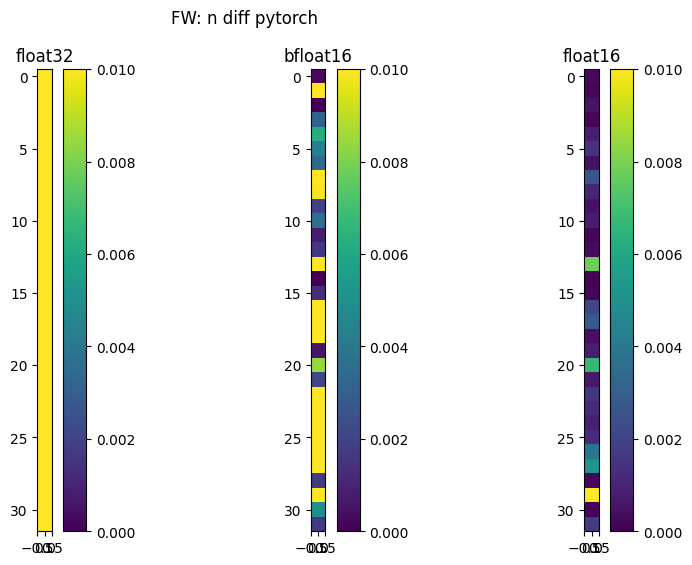

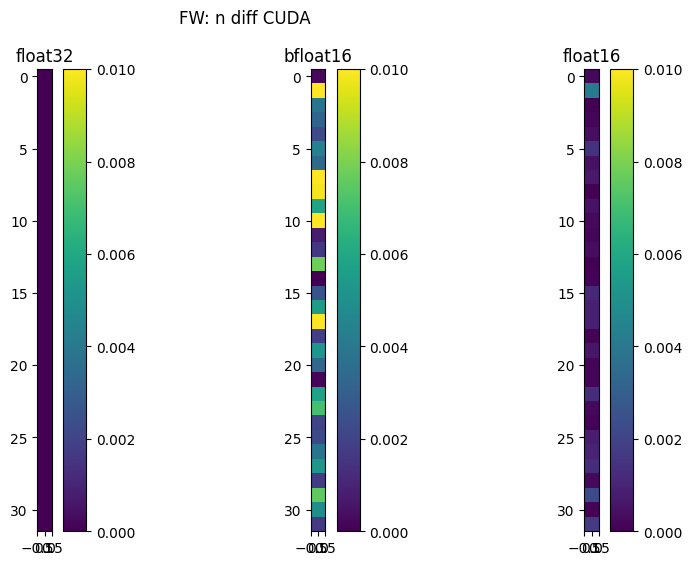

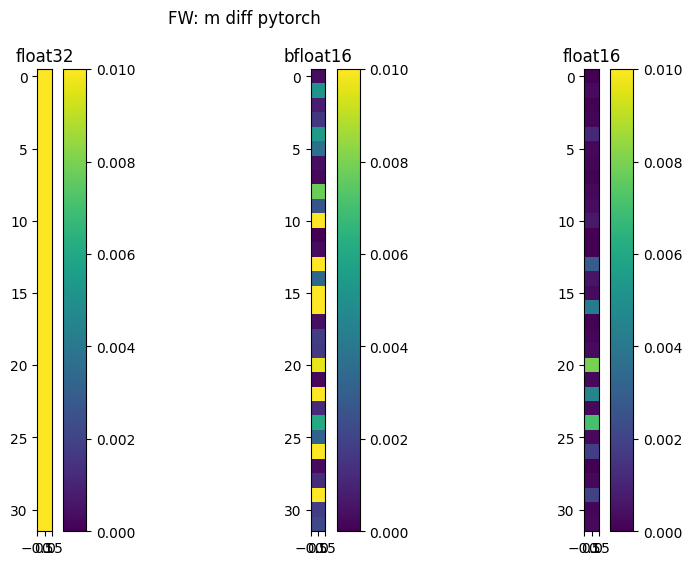

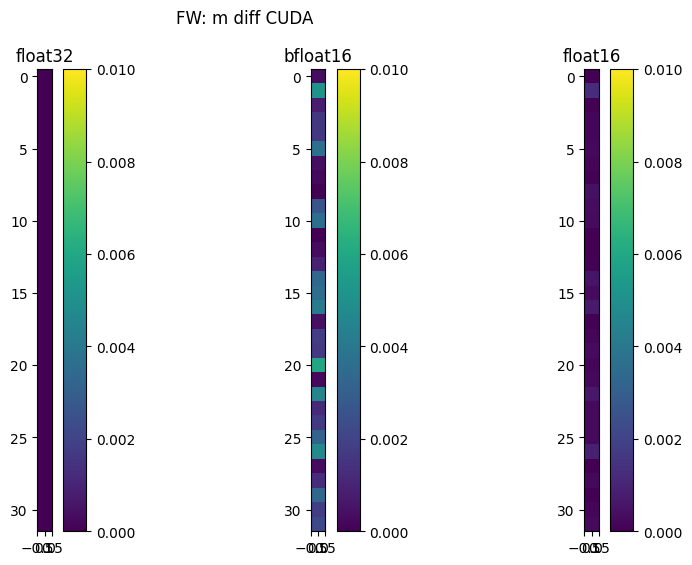

In [26]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")

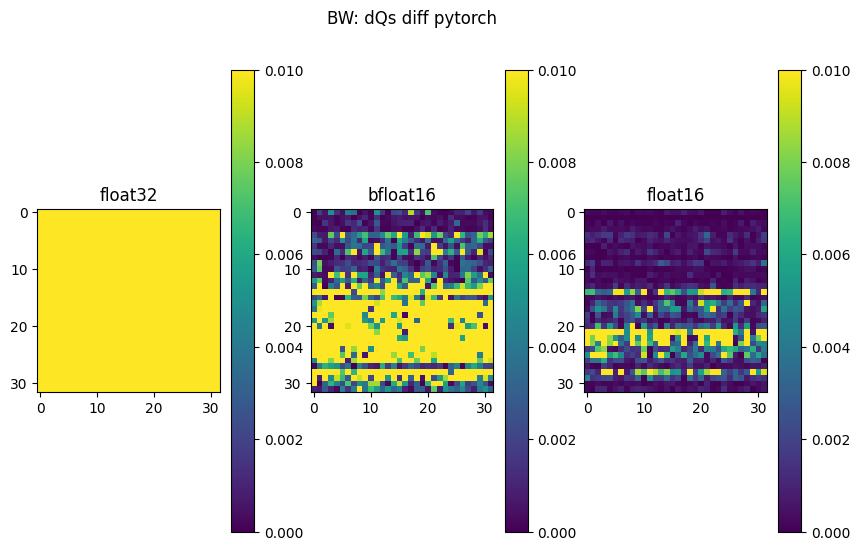

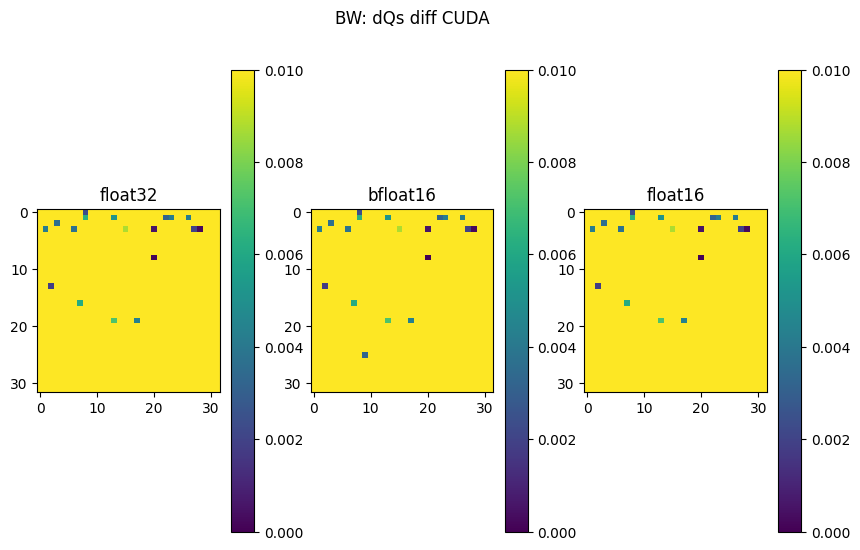

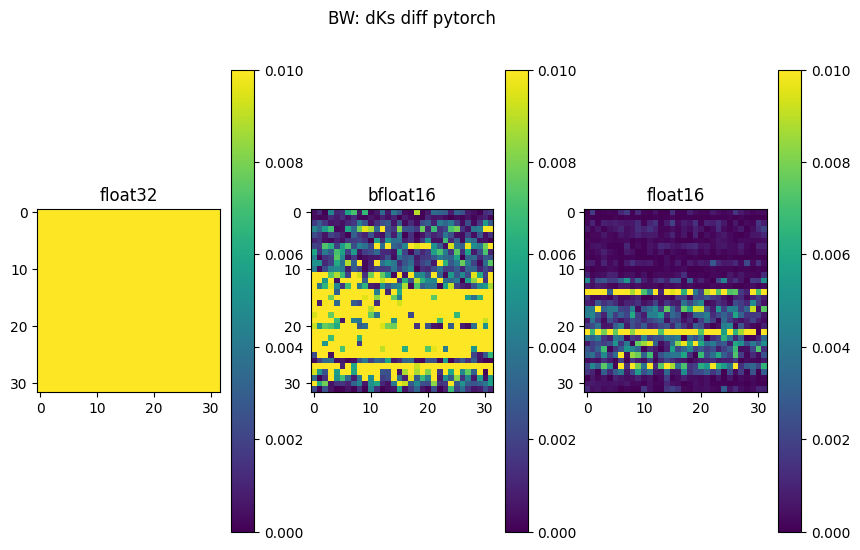

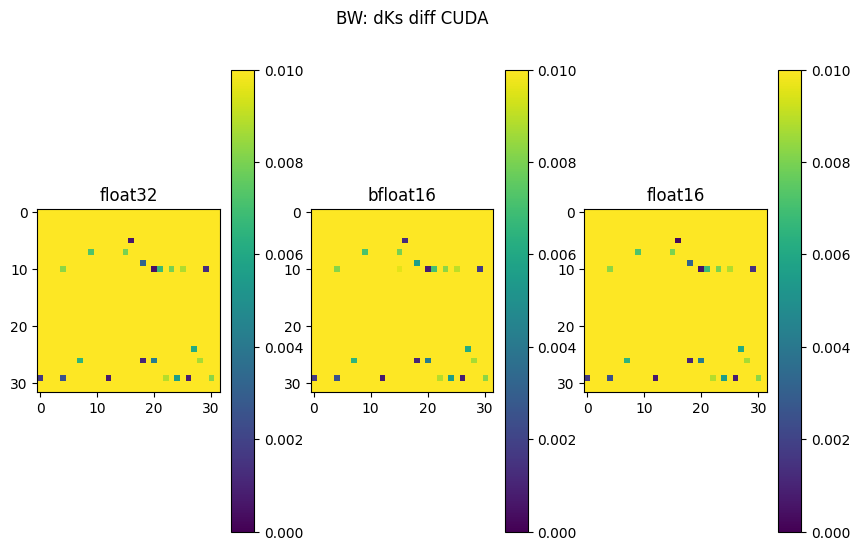

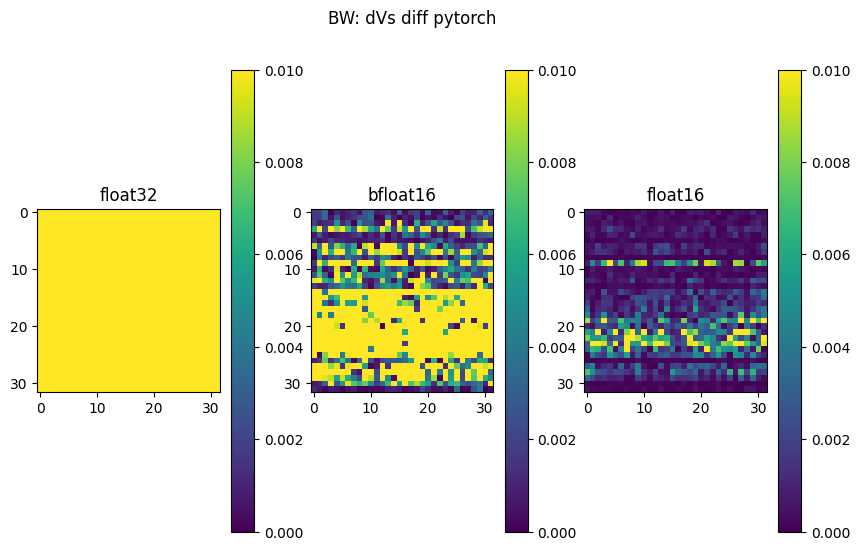

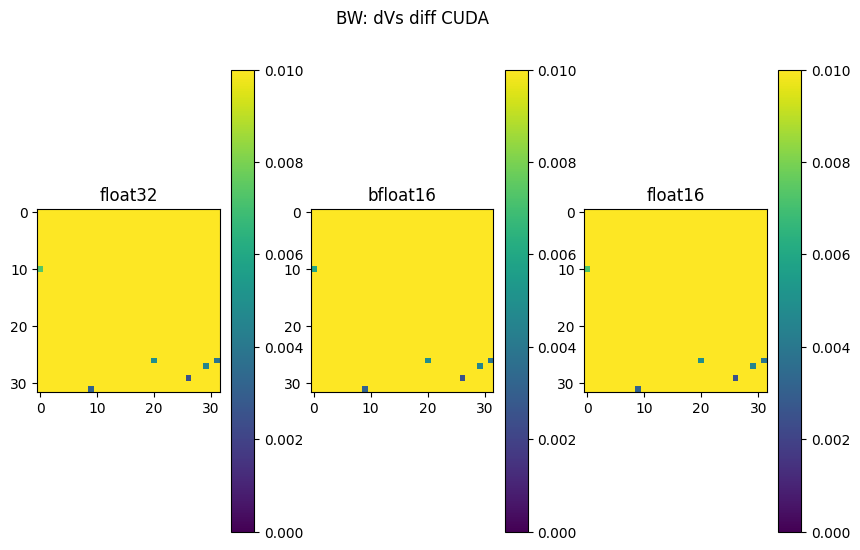

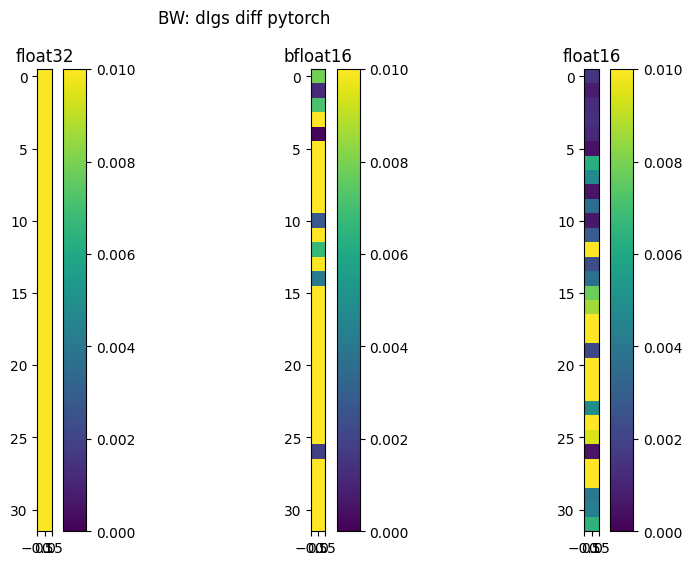

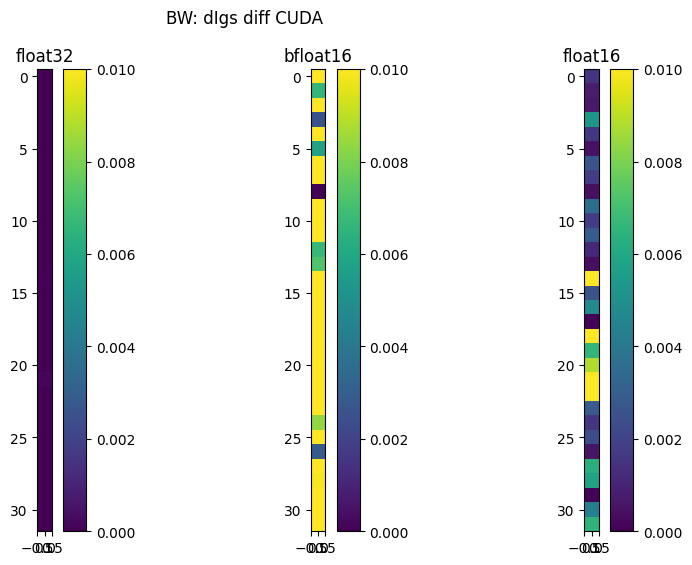

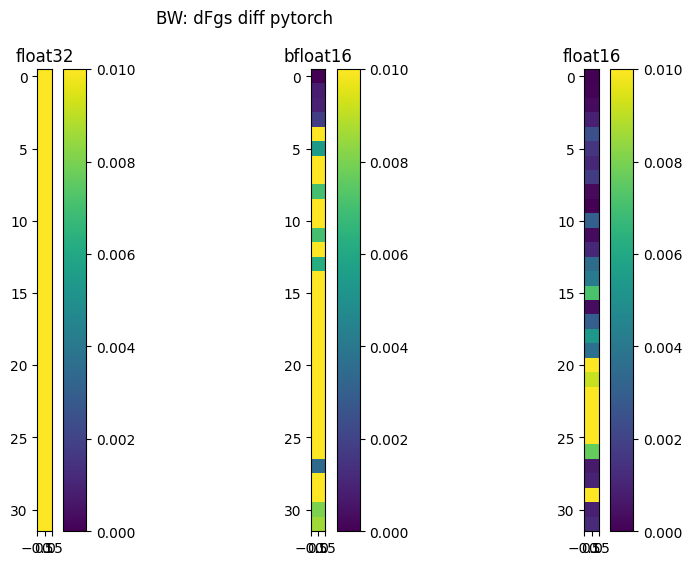

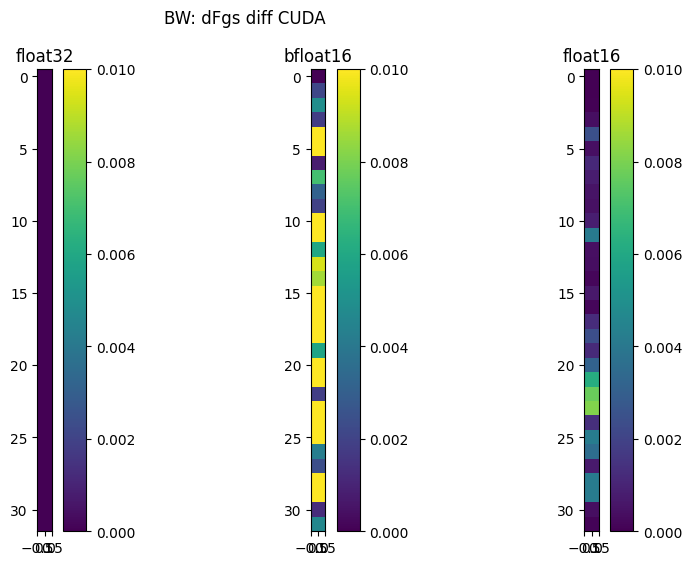

In [27]:
# bw diffs
# dQs
fig = plot_numerical_diffs(dQs_pt, 10*torch.ones_like(dQs_pt), dQs_pt_bf16, dQs_pt_half, title="BW: dQs diff pytorch")
fig = plot_numerical_diffs(dQs_pt, dQs_cu, dQs_cu_bf16, dQs_cu_half, title="BW: dQs diff CUDA")
# dKs
fig = plot_numerical_diffs(dKs_pt, 10*torch.ones_like(dKs_pt), dKs_pt_bf16, dKs_pt_half, title="BW: dKs diff pytorch")
fig = plot_numerical_diffs(dKs_pt, dKs_cu, dKs_cu_bf16, dKs_cu_half, title="BW: dKs diff CUDA")
# dVs
fig = plot_numerical_diffs(dVs_pt, 10*torch.ones_like(dVs_pt), dVs_pt_bf16, dVs_pt_half, title="BW: dVs diff pytorch")
fig = plot_numerical_diffs(dVs_pt, dVs_cu, dVs_cu_bf16, dVs_cu_half, title="BW: dVs diff CUDA")
# dIgs
fig = plot_numerical_diffs(dIgs_pt, 10*torch.ones_like(dIgs_pt), dIgs_pt_bf16, dIgs_pt_half, title="BW: dIgs diff pytorch")
fig = plot_numerical_diffs(dIgs_pt, dIgs_cu, dIgs_cu_bf16, dIgs_cu_half, title="BW: dIgs diff CUDA")
# dFgs
fig = plot_numerical_diffs(dFgs_pt, 10*torch.ones_like(dFgs_pt), dFgs_pt_bf16, dFgs_pt_half, title="BW: dFgs diff pytorch")
fig = plot_numerical_diffs(dFgs_pt, dFgs_cu, dFgs_cu_bf16, dFgs_cu_half, title="BW: dFgs diff CUDA")

### Debug float16 precision differences in cuda kernel

In [28]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [29]:
fgs

tensor([[[[-1.4286],
          [-1.0874],
          [ 0.5559],
          [ 1.0172],
          [-0.3479],
          [-1.3633],
          [-1.3168],
          [ 0.9415],
          [ 0.5776],
          [-0.4001],
          [-0.4550],
          [-0.5947],
          [-2.3788],
          [ 0.0537],
          [ 0.5271],
          [-0.2673],
          [ 0.1509],
          [ 0.3151],
          [-0.8073],
          [ 0.9548],
          [-0.7206],
          [ 0.2526],
          [ 0.8241],
          [-0.6592],
          [ 0.7642],
          [ 0.0181],
          [-0.6598],
          [ 0.6114],
          [ 0.2609],
          [-0.6826],
          [-0.8559],
          [-1.3082]]]], device='cuda:0')

In [30]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 21120
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [31]:
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")

====== Half ======
fw hs match: False, max diff: 0.012780904769897461
fw n match: False, max diff: 0.00409388542175293
fw m match: False, max diff: 0.0012853145599365234
fw D match: False, max diff: 1.359375


In [32]:
# matS = (qs @ ks.transpose(-2, -1) / (DH ** 0.5)).tril()
# matS[:,:, :, :10]

In [33]:
# (matD_cu_half - matS)[:, :, :, :10]

In [34]:
torch.nn.functional.logsigmoid(fgs_half)

tensor([[[[-1.6436],
          [-1.3779],
          [-0.4531],
          [-0.3086],
          [-0.8823],
          [-1.5908],
          [-1.5537],
          [-0.3293],
          [-0.4456],
          [-0.9131],
          [-0.9463],
          [-1.0342],
          [-2.4668],
          [-0.6665],
          [-0.4641],
          [-0.8359],
          [-0.6206],
          [-0.5479],
          [-1.1758],
          [-0.3257],
          [-1.1172],
          [-0.5747],
          [-0.3638],
          [-1.0762],
          [-0.3823],
          [-0.6841],
          [-1.0762],
          [-0.4336],
          [-0.5713],
          [-1.0918],
          [-1.2100],
          [-1.5479]]]], device='cuda:0', dtype=torch.float16)

In [35]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-1.6434],
          [-1.3779],
          [-0.4533],
          [-0.3087],
          [-0.8822],
          [-1.5911],
          [-1.5542],
          [-0.3293],
          [-0.4455],
          [-0.9131],
          [-0.9463],
          [-1.0341],
          [-2.4675],
          [-0.6667],
          [-0.4639],
          [-0.8357],
          [-0.6205],
          [-0.5480],
          [-1.1761],
          [-0.3256],
          [-1.1170],
          [-0.5748],
          [-0.3637],
          [-1.0761],
          [-0.3823],
          [-0.6841],
          [-1.0765],
          [-0.4335],
          [-0.5712],
          [-1.0916],
          [-1.2100],
          [-1.5475]]]], device='cuda:0')

In [36]:
matD_cu_half[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[ 1.6956e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-1.2070e+00, -1.2969e+00,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-1.6602e+00, -1.7500e+00,  3.1519e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-1.9688e+00, -2.0586e+00,  6.8359e-03,  9.1943e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-2.8516e+00, -2.9395e+00, -8.7500e-01,  3.7598e-02, -1.8530e-01,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-4.4414e+00, -4.5312e+00, -2.4648e+00, -1.5527e+00, -1.7764e+00, -1.0898e+00,        -inf,        -inf,        -inf,        -inf],
           [-5.9961e+00, -6.0859e+00, -4.0195e+00, -3.1074e+00, -3.3301e+00, -2.6445e+00, -2.6318e-01,        -inf,        -inf,        -inf],

### debug fw hs nans in last timesteps

In [37]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [38]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 21120
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [39]:
hs_cu_half[:, :, 20:30, :10]

tensor([[[[ 7.1094e-01, -9.2432e-01,  7.5244e-01,  1.1357e+00, -1.3125e+00, -2.0664e+00,  8.3301e-01, -2.4551e+00,  3.8086e-02,  4.0955e-02],
          [-1.5059e+00, -1.0156e+00,  1.2373e+00, -1.8809e+00, -9.6533e-01,  2.5605e+00, -6.0547e-01,  3.1582e+00,  5.1689e-03,  1.4160e+00],
          [ 4.8975e-01,  1.6250e+00, -3.6797e+00,  2.1445e+00,  2.3066e+00, -2.2344e+00,  3.9551e-02, -1.7148e+00, -4.8828e-01, -1.0439e+00],
          [-2.0625e+00, -4.1914e+00, -2.1621e+00, -5.9336e+00, -1.4531e+00,  5.5469e+00, -1.5244e+00,  4.4062e+00,  3.0605e+00,  1.8223e+00],
          [ 3.5034e-01, -1.0088e+00,  2.7500e+00, -1.6807e+00, -1.6357e+00,  1.2354e+00, -8.5693e-02,  1.4561e+00,  5.9180e-01,  1.2822e+00],
          [-3.4805e+00,  1.9600e+00, -1.8896e+00,  6.5137e-01,  2.6074e+00,  7.8516e-01, -1.3599e-01,  1.3350e+00, -1.1768e+00,  1.5791e+00],
          [ 8.4717e-01,  1.3496e-02, -1.4541e+00,  4.3921e-01, -6.3538e-02, -4.5508e-01,  2.6953e-01, -1.0654e+00,  1.5540e-01, -8.6523e-01],
      

In [40]:
n_cu[:, :, 120:]

tensor([], device='cuda:0', size=(1, 1, 0, 1))

In [41]:
(hs_cu-hs_pt)[:, :, 120:, :10]

tensor([], device='cuda:0', size=(1, 1, 0, 10))

In [42]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 3.6716461181640625e-05
fw n match: True, max diff: 5.7220458984375e-06
fw m match: True, max diff: 3.5762786865234375e-06
fw D match: False, max diff: 1.3591573238372803


### debug fw hs for Q64xKV64

**Not working:** Possible reason for Q64xKV64 we use too much shared memory than available on the the laptop gpu.

In [43]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [44]:
(hs_cu - hs_pt)[:,:, :10, :10] 

tensor([[[[-2.9802e-08, -5.2154e-08,  4.4703e-08,  1.4901e-08,  2.6077e-08,  3.7253e-08, -3.7253e-08,  8.9407e-08,  9.3132e-09,  1.3039e-08],
          [-1.4901e-08,  2.9802e-08, -1.1921e-07,  2.9802e-08,  4.4703e-08, -5.9605e-08,  1.1921e-07, -1.4901e-08,  5.9605e-08, -8.9407e-08],
          [ 0.0000e+00, -7.4506e-09,  2.9802e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.9802e-08,  0.0000e+00,  0.0000e+00],
          [-4.4703e-08,  0.0000e+00, -1.1921e-07, -2.3842e-07, -2.3842e-07,  1.1921e-07,  2.3842e-07,  0.0000e+00, -1.1921e-07, -2.9802e-08],
          [-1.1921e-07, -9.5367e-07, -4.7684e-07, -5.9605e-08,  4.3772e-08,  3.5763e-07,  3.5763e-07,  4.7684e-07, -1.7881e-07, -1.1921e-07],
          [-1.4901e-08,  0.0000e+00,  2.9802e-08,  2.9802e-08, -2.2352e-08, -5.9605e-08, -2.9802e-08, -5.2154e-08, -8.9407e-08,  0.0000e+00],
          [-1.4901e-08,  1.1921e-07,  5.2154e-08, -1.4901e-08, -5.9605e-08,  5.9605e-08,  5.9605e-08, -1.4901e-07, -1.0431e-07,  5.9605e-08],
      

In [45]:
(hs_cu)[:,:, :8, :10] 

tensor([[[[ 0.0662,  0.1164, -0.0949, -0.0369, -0.0543, -0.0849,  0.0664, -0.2108, -0.0232, -0.0275],
          [ 0.1011, -0.1352,  0.6614, -0.1213, -0.2187,  0.1955, -0.4856,  0.1892, -0.2480,  0.3506],
          [ 0.2149,  0.0476,  0.4171,  2.0345,  2.1339, -0.5256, -1.2907, -0.4263,  0.4714,  0.2461],
          [-0.0800, -2.0850, -1.8355, -1.1837,  0.1024,  1.3610,  1.7972,  2.9755,  1.1028, -0.4684],
          [ 0.6126,  3.6316,  1.8998,  0.3644,  0.0037, -0.8326, -1.0056, -3.5250,  0.7319,  0.6287],
          [ 0.0336,  0.1353, -0.3010, -0.4251,  0.1067,  0.5722,  0.3286,  0.0730,  0.1241,  0.1140],
          [-0.2137, -0.2766, -0.0816, -0.2077,  0.5795, -0.4050, -0.6026,  0.3682, -0.0317, -0.4180],
          [-0.2922, -2.8473,  0.8812, -1.5637, -2.0510, -0.7217, -0.4277,  0.5156, -0.6132, -0.5318]]]], device='cuda:0')

In [46]:
(hs_pt)[:,:, :8, :10] 

tensor([[[[ 0.0662,  0.1164, -0.0949, -0.0369, -0.0543, -0.0849,  0.0664, -0.2108, -0.0232, -0.0275],
          [ 0.1011, -0.1352,  0.6614, -0.1213, -0.2187,  0.1955, -0.4856,  0.1892, -0.2480,  0.3506],
          [ 0.2149,  0.0476,  0.4171,  2.0345,  2.1339, -0.5256, -1.2907, -0.4263,  0.4714,  0.2461],
          [-0.0800, -2.0850, -1.8355, -1.1837,  0.1024,  1.3610,  1.7972,  2.9755,  1.1028, -0.4684],
          [ 0.6126,  3.6316,  1.8998,  0.3644,  0.0037, -0.8326, -1.0056, -3.5250,  0.7319,  0.6287],
          [ 0.0336,  0.1353, -0.3010, -0.4251,  0.1067,  0.5722,  0.3286,  0.0730,  0.1241,  0.1140],
          [-0.2137, -0.2766, -0.0816, -0.2077,  0.5795, -0.4050, -0.6026,  0.3682, -0.0317, -0.4180],
          [-0.2922, -2.8473,  0.8812, -1.5637, -2.0510, -0.7217, -0.4277,  0.5156, -0.6132, -0.5318]]]], device='cuda:0')

In [47]:
(matD_cu - matD_pt)[:,:, :10, :10] 

tensor([[[[-0.8304,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-2.2083, -2.2121,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-1.8001, -1.8767, -0.6847,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-2.0259, -2.1095, -0.3947, -0.0804,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-2.9081, -2.9917, -1.2769, -0.9626, -0.9856,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-4.4785, -4.5638, -2.7190, -2.1824, -2.2796, -2.0896,    -inf,    -inf,    -inf,    -inf],
          [-6.0010, -6.0890, -4.0442, -3.1660, -3.3771, -2.7364, -1.2633,    -inf,    -inf,    -inf],
          [-6.3283, -6.4165, -4.3590, -3.4591, -3.6775, -3.0080, -0.9696, -0.6170,    -inf,    -inf],
          [-6.7738, -6.8620, -4.8045, -3.9046, -4.1229, -3.4535, -1.4151, -1.0625, -1.2006,    -inf],
          [-7.6857, -7.7740, -5.7095, -4.7977, -5.0200, -4.3349, -1.9853, -1.0660,

In [48]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 3.6716461181640625e-05
fw n match: True, max diff: 5.7220458984375e-06
fw m match: True, max diff: 3.5762786865234375e-06
fw D match: False, max diff: 1.3591573238372803


In [49]:
(matD_pt_half - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -4.3637e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 5.0411e-05,  3.8266e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.8959e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.3111e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00, -1.0080e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.6937e-05,  1.9595e-05,  6.0183e-04,  2.0962e-03,  6.9177e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 3.3574e-07, -4.9016e-06,  3.6132e-05,  2.8056e-04,  5.2996e-05, -3.1762e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [50]:
(matD_pt_bf16 - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.3192e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.1490e-03,  1.6034e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -9.1767e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -2.8708e-03,  0.0000e+00, -3.4494e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-7.6756e-04,  2.3322e-04, -2.3279e-03,  1.4311e-04, -5.1676e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.5034e-04, -1.5177e-04, -1.4697e-04, -5.5138e-05, -4.0477e-04, -7.0315e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [51]:
(matD_pt_bf16)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1016e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3965e-01, 1.2695e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 4.0039e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 3.9844e-01, 1.0000e+00, 7.9688e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4180e-02, 3.2227e-02, 2.5000e-01, 6.2891e-01, 4.9805e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.0823e-03, 2.8076e-03, 2.3193e-02, 5.8105e-02, 4.6143e-02, 9.1797e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2054e-03, 1.0986e-03, 8.9111e-03, 2.2095e-02, 1.7700e-02, 3.540

### debug q16xkv16 tile size backward

In [52]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_C_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [53]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 16-16, shared_mem in bytes: 41088
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 32
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 28096
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 16, KVtileDim: 16, TblockDim:4
BIdx(0,0),TIdx(0,0),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,0), : dC=3.660282,Dstr=1.000000,S=0.003233 - P=3.660282,R=0.003233
BIdx(0,0),TIdx(0,1),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,1), : dC=0.288379,Dstr=1.000000,S=0.001219 - P=0.288379,R=0.001219
BIdx(0,0),TIdx(0,2),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,2), : dC=-3.492333,Dstr=0.138499,S=0.001219 - P=-0.483686,R=0.000169
BIdx(0,0),TIdx(0,3),ij=(0,0), sTileXYIdx(0,0), prWTIdx(0,3), : dC=-1.816332,Dstr=0.055581,S=0.000110 - P=-0.100953,R=0.000006
BIdx(0,0),T

In [54]:
# mat_P_pt[:, :, :16, :9]

In [55]:
# mat_R_pt[:, :, :16, :9]

In [56]:
delta_C_pt[:, :, :16, :9]

tensor([[[[ 3.6603e+00, -3.6564e+00,  8.7304e+00,  9.7454e+00, -7.6454e+00,  7.5035e+00,  5.2817e+00,  1.9204e+00,  9.5010e+00],
          [ 2.8838e-01, -2.9151e-02, -7.1263e-01,  1.6605e-01,  1.6778e+00, -7.9380e-01,  3.8582e+00,  1.0825e-01,  1.0936e+00],
          [-3.4923e+00,  4.8771e+00, -3.1702e+00,  2.9198e+00,  1.5227e+01, -1.4074e+01,  1.8535e+00, -1.8780e+00,  1.9614e+00],
          [-1.8163e+00,  1.1249e+01,  1.0939e+00,  2.8987e-01,  1.2630e+01, -1.1553e+01,  7.7004e+00,  1.0698e+01,  1.0951e+01],
          [-1.8476e+00,  2.7655e-01,  6.1334e+00, -4.8701e+00,  1.2727e+00, -8.9462e+00,  2.9786e-01,  4.1855e-03, -4.7773e+00],
          [ 2.4242e-01,  1.3981e+00, -2.6908e+00,  1.8937e+00, -4.3918e+00, -1.6199e+00, -8.9162e-01,  3.2340e+00,  3.4577e+00],
          [-2.6691e+00,  1.1057e+01, -5.8557e+00, -6.1066e+00, -7.9840e+00, -7.8367e+00, -1.9328e+00, -1.5803e+00, -4.5958e+00],
          [-1.0390e+00, -1.2785e+00, -8.0685e-01,  1.7396e+00,  4.0968e-01, -2.9453e+00,  2.7662e

In [57]:
matS = qs @ ks.transpose(-2, -1) / (DH ** 0.5)
matS[:,:, :16, :9], (matC_cu-matS).abs().max() #(matC_cu-matS)[:,:,:16,:9]

(tensor([[[[-0.0961, -1.8711,  0.9341, -1.3155, -0.9150, -0.4050, -0.7507,  1.6704, -1.1101],
           [ 0.6510,  0.9283, -0.6924,  1.2197,  2.2210,  0.3152, -1.7155,  0.0756, -1.8405],
           [-0.2012, -0.8635,  0.9225,  0.7662, -0.7581, -1.7819,  0.9815, -0.8251,  1.2308],
           [ 1.5852, -0.6699, -0.7249,  0.9823, -0.8449, -1.0497,  1.2888, -0.3716,  1.6619],
           [-0.7649,  1.2462, -0.2735, -1.1995,  1.0055, -1.1140, -0.1066,  0.7551,  0.1469],
           [ 1.4173, -0.1924, -0.4866,  0.2352,  0.8274, -0.7731,  0.8315,  0.1133,  0.5467],
           [ 0.4663,  0.2220,  0.2428,  2.3131, -0.2464,  1.5706, -0.5495, -0.2174,  0.1944],
           [-1.1484, -1.6549, -0.2404, -0.5273, -1.5675, -1.0082, -1.4876,  2.6845, -1.2404],
           [-0.4970, -1.5021, -0.1295,  0.3962, -0.3559,  0.6643, -0.8605, -0.9321, -0.8378],
           [ 0.5130,  0.7713,  0.0527, -0.4008, -0.4361, -0.3165,  0.3729,  0.3070,  1.2066],
           [-0.6069, -0.1790,  2.2517, -0.3118,  1.2299, -0.

In [58]:
matD_pt[:, :, :16, :9]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1548e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3850e-01, 1.2679e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 8.0032e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4947e-02, 3.1993e-02, 2.5233e-01, 6.2876e-01, 5.0321e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.2326e-03, 2.9594e-03, 2.3340e-02, 5.8161e-02, 4.6547e-02, 9.2500e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2185e-03, 1.1155e-03, 8.7981e-03, 2.1923e-02, 1.7546e-02, 3.4868e-02, 3.7695e-01, 1.0000e+00, 0.0000e+00],
          [1.2185e-03, 1.1155e-03, 8.798

In [59]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: True, max diff: 3.6716461181640625e-05
fw n match: True, max diff: 5.7220458984375e-06
fw m match: True, max diff: 3.5762786865234375e-06
fw D match: True, max diff: 1.430511474609375e-06
---------------------------------
bw dQs match: False, max diff: 154.60035705566406
bw dKs match: False, max diff: 164.1123046875
bw dVs match: False, max diff: 156.4673614501953
bw dIgs match: True, max diff: 0.00012230873107910156
bw dFgs match: True, max diff: 2.5272369384765625e-05


In [60]:
# dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt

In [61]:
mat_P_pt[:, :, -20:, :10]

tensor([[[[-5.5251e-06, -1.5995e-05, -2.5881e-04,  1.8152e-03, -1.2467e-03, -7.6135e-04,  4.4670e-03,  1.6961e-02,  2.3485e-02,  3.0811e-01],
          [ 7.2490e-07,  8.0229e-08, -1.5696e-04,  2.9032e-04, -1.7346e-04,  2.1141e-04,  5.7983e-03,  2.6972e-03, -3.3780e-04, -2.6627e-01],
          [ 1.9626e-07, -1.3526e-06,  8.0248e-05,  2.9215e-04,  1.0605e-04, -3.6257e-05,  2.0775e-04,  4.0716e-03,  1.8529e-04,  1.5550e-01],
          [-1.3196e-08, -6.8736e-09,  1.0408e-05,  2.2027e-05,  3.5173e-05,  3.1660e-05,  2.3576e-04,  1.9585e-03, -3.3944e-04, -3.0438e-04],
          [-5.1231e-07, -3.6731e-07, -2.1262e-05,  1.5934e-05,  1.3744e-05, -1.0476e-04, -1.7061e-04,  8.9082e-04,  8.4758e-04, -4.4965e-02],
          [ 2.3535e-06,  6.6440e-07,  3.6502e-06, -1.1823e-05, -2.3809e-05,  4.9444e-05,  4.9825e-04, -2.1707e-04, -6.9506e-04,  1.0909e-02],
          [-3.9921e-07, -2.5468e-07, -2.9045e-06,  5.5071e-06,  2.2375e-06,  2.7991e-06, -3.6931e-05,  3.0942e-04, -3.1796e-04, -3.8265e-03],
      

In [62]:
matC_cu[:, :, -20:, :10]

tensor([[[[-3.7184e-01,  1.9875e+00, -9.8146e-01, -5.8261e-01,  7.1358e-01, -8.6362e-01,  2.7394e-01, -3.6485e-01,  2.9972e-01, -1.7556e-01],
          [ 8.6178e-01, -1.1246e+00, -4.3805e-01, -5.4149e-01, -1.2986e+00, -2.7178e-01, -2.2713e+00,  1.9447e-01,  8.4857e-01,  1.5431e+00],
          [ 9.9911e-02, -8.5423e-01,  8.6583e-01, -7.3744e-01,  2.1802e+00,  5.6971e-01,  2.5947e-01, -1.1210e+00, -1.3050e+00,  2.2841e+00],
          [ 2.3020e-01,  1.6990e+00, -3.8256e-01,  4.8678e-01,  9.6465e-01, -5.7042e-01, -3.5001e-01,  1.2593e+00,  6.6398e-01,  8.0809e-01],
          [ 9.0683e-10,  8.3018e-10,  6.5476e-09,  1.6316e-08,  1.3058e-08,  2.5949e-08,  2.8052e-07,  7.4420e-07,  4.1832e-07,  8.2248e-06],
          [ 8.0353e-10,  7.3561e-10,  5.8017e-09,  1.4457e-08,  1.1570e-08,  2.2993e-08,  2.4857e-07,  6.5943e-07,  3.7067e-07,  7.2879e-06],
          [ 8.0353e-10,  7.3562e-10,  5.8017e-09,  1.4457e-08,  1.1570e-08,  2.2993e-08,  2.4857e-07,  6.5943e-07,  3.7067e-07,  7.2879e-06],
      

In [63]:
(matC_cu-mat_P_pt)[:, :, -20:, :10], torch.abs((matC_cu-mat_P_pt)).max()

(tensor([[[[-3.7184e-01,  1.9875e+00, -9.8120e-01, -5.8442e-01,  7.1483e-01, -8.6286e-01,  2.6947e-01, -3.8182e-01,  2.7624e-01, -4.8366e-01],
           [ 8.6178e-01, -1.1246e+00, -4.3789e-01, -5.4178e-01, -1.2985e+00, -2.7199e-01, -2.2771e+00,  1.9178e-01,  8.4891e-01,  1.8094e+00],
           [ 9.9910e-02, -8.5423e-01,  8.6575e-01, -7.3773e-01,  2.1801e+00,  5.6974e-01,  2.5926e-01, -1.1251e+00, -1.3052e+00,  2.1286e+00],
           [ 2.3020e-01,  1.6990e+00, -3.8257e-01,  4.8676e-01,  9.6461e-01, -5.7045e-01, -3.5025e-01,  1.2574e+00,  6.6432e-01,  8.0840e-01],
           [ 5.1321e-07,  3.6814e-07,  2.1268e-05, -1.5918e-05, -1.3731e-05,  1.0479e-04,  1.7089e-04, -8.9007e-04, -8.4717e-04,  4.4973e-02],
           [-2.3527e-06, -6.6367e-07, -3.6444e-06,  1.1838e-05,  2.3821e-05, -4.9421e-05, -4.9801e-04,  2.1773e-04,  6.9543e-04, -1.0902e-02],
           [ 4.0001e-07,  2.5542e-07,  2.9103e-06, -5.4927e-06, -2.2259e-06, -2.7761e-06,  3.7179e-05, -3.0876e-04,  3.1833e-04,  3.8337e-03],

In [64]:
(matC_cu-mat_R_pt)[:, :, -20:, :10], torch.abs((matC_cu-mat_R_pt)).max()

(tensor([[[[-3.7184e-01,  1.9874e+00, -9.8140e-01, -5.8253e-01,  7.1350e-01, -8.6343e-01,  2.7329e-01, -3.6259e-01,  2.9868e-01, -1.6351e-01],
           [ 8.6177e-01, -1.1246e+00, -4.3802e-01, -5.4142e-01, -1.2985e+00, -2.7172e-01, -2.2660e+00,  1.9327e-01,  8.4561e-01,  1.4372e+00],
           [ 9.9911e-02, -8.5423e-01,  8.6583e-01, -7.3744e-01,  2.1802e+00,  5.6970e-01,  2.5945e-01, -1.1208e+00, -1.3048e+00,  2.2793e+00],
           [ 2.3020e-01,  1.6990e+00, -3.8256e-01,  4.8678e-01,  9.6464e-01, -5.7041e-01, -3.4998e-01,  1.2591e+00,  6.6391e-01,  8.0640e-01],
           [-1.7106e-07, -1.3695e-07,  2.4135e-06,  7.3199e-06, -5.4802e-06,  6.0469e-06,  1.0357e-04, -1.7754e-04,  1.2548e-05,  4.1194e-03],
           [-8.1033e-08, -1.1741e-07,  1.7457e-06,  1.2163e-07,  5.1627e-06, -5.2884e-06, -5.0635e-05, -3.2296e-04, -7.3777e-05,  2.8388e-03],
           [ 1.1745e-08, -2.8782e-08, -6.7481e-09, -7.6563e-07, -3.1616e-07,  6.5239e-07, -1.8928e-06, -1.7067e-06, -9.4003e-06,  7.2917e-04],

In [65]:
matS = qs @ ks.transpose(-2, -1) / (DH ** 0.5)

In [66]:
(matC_cu-matS)[:, :, -20:, :10], torch.abs((matC_cu-matS)).max()

(tensor([[[[ 2.9802e-08, -1.1921e-07,  1.1921e-07,  5.9605e-08, -5.9605e-08,  5.9605e-08, -2.9802e-08,  2.9802e-08, -2.9802e-08,  1.4901e-08],
           [-5.9605e-08,  1.1921e-07,  2.9802e-08,  0.0000e+00,  1.1921e-07,  2.9802e-08,  2.3842e-07, -2.9802e-08, -1.1921e-07, -1.1921e-07],
           [-7.4506e-09,  5.9605e-08, -1.1921e-07,  5.9605e-08, -2.3842e-07, -5.9605e-08, -2.9802e-08,  1.1921e-07,  1.1921e-07, -2.3842e-07],
           [-1.4901e-08, -1.1921e-07,  2.9802e-08, -2.9802e-08, -1.1921e-07,  5.9605e-08,  2.9802e-08, -1.1921e-07,  0.0000e+00, -5.9605e-08],
           [-7.4609e-01, -6.5298e-01,  1.4463e+00,  1.7612e+00, -1.6552e+00,  9.1292e-01,  1.4486e+00, -9.4253e-01,  1.1408e-01,  1.9667e+00],
           [-4.2967e-01, -6.7755e-01,  1.2652e+00,  3.1275e-02,  1.8782e+00, -9.7457e-01, -8.6360e-01, -2.0704e+00, -8.4393e-01,  1.6391e+00],
           [ 2.6870e-01, -7.9185e-01, -4.2687e-02, -1.0648e+00, -5.5897e-01,  5.4019e-01, -1.7000e-01, -7.0807e-02, -5.2019e-01,  1.9547e+00],

In [67]:
(matC_cu-delta_Dtilde_pt)[:, :, -20:, :10], torch.abs((matC_cu-delta_Dtilde_pt)).max()

(tensor([[[[-3.7185e-01,  1.9875e+00, -9.8171e-01, -5.8155e-01,  7.1447e-01, -8.6427e-01,  2.7271e-01, -3.5867e-01,  2.9269e-01, -1.2147e-01],
           [ 8.6178e-01, -1.1246e+00, -4.3811e-01, -5.4134e-01, -1.2989e+00, -2.7172e-01, -2.2581e+00,  1.9395e-01,  8.4886e-01,  1.9540e+00],
           [ 9.9911e-02, -8.5423e-01,  8.6576e-01, -7.3723e-01,  2.1800e+00,  5.6973e-01,  2.5941e-01, -1.1164e+00, -1.3047e+00,  1.9289e+00],
           [ 2.3020e-01,  1.6990e+00, -3.8255e-01,  4.8677e-01,  9.6461e-01, -5.7040e-01, -3.4993e-01,  1.2569e+00,  6.6421e-01,  8.0834e-01],
           [ 3.8314e-07,  2.4068e-07, -3.0744e-05,  2.8080e-05, -2.2735e-05, -9.5615e-05, -2.4687e-04, -8.3888e-04,  9.7110e-05, -8.8422e-02],
           [-1.0104e-06, -4.4943e-07,  4.6241e-06, -3.5532e-07, -4.4708e-05, -4.8163e-05, -4.3005e-04,  4.5008e-04,  5.8695e-04,  1.7889e-02],
           [-1.0646e-07,  2.0241e-07,  1.2979e-07, -5.8496e-06, -1.2391e-06,  1.5350e-06,  6.5269e-06, -2.1250e-05,  1.6577e-04, -7.4722e-03],

In [68]:
(matC_cu-delta_D_pt)[:, :, -20:, :10], torch.abs((matC_cu-delta_D_pt)).max()

(tensor([[[[-6.4327e-01,  6.5750e+00, -5.6293e+00,  7.1828e+00,  8.8758e+00, -3.8994e+00, -2.4866e-01,  6.3139e-01, -1.7162e+00,  6.1234e-01],
           [ 7.7925e-01, -1.1116e+00, -1.6961e+00,  6.1287e-01, -3.3655e+00, -6.4960e-03,  3.3531e+00,  1.1003e-01,  9.3067e-01,  7.5284e+00],
           [ 1.4835e-02, -6.3299e+00, -4.0885e+01,  5.1215e+01, -6.7485e+01,  3.7016e+00, -4.9654e-01,  2.3009e+01,  9.6918e-01, -1.6763e+02],
           [ 2.4338e-01,  1.7544e+00,  2.0100e+00, -2.0988e+00, -9.2585e+00,  2.1678e+00,  8.0734e-01, -1.1780e+01,  2.7838e+00,  9.2575e-01],
           [ 1.6583e+00,  1.1367e+00, -1.8478e+01,  6.7675e+00, -6.8542e+00, -1.4501e+01, -3.4663e+00, -4.4389e+00,  9.0942e-01, -4.2301e+01],
           [-5.3093e+00, -2.5817e+00,  3.3583e+00, -1.0791e-01, -1.6306e+01, -8.8414e+00, -7.3031e+00,  2.8752e+00,  6.6763e+00,  1.0352e+01],
           [-2.6344e+00,  5.4101e+00,  4.2172e-01, -8.0045e+00, -2.1331e+00,  1.2977e+00,  4.9843e-01, -6.5565e-01,  8.8058e+00, -2.0253e+01],

In [69]:
(matC_cu-matD_pt)[:, :, :20, :10]

tensor([[[[-9.9677e-01,  2.9594e-03,  2.3340e-02,  5.8161e-02,  4.6547e-02,  9.2500e-02,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-9.9878e-01, -9.1436e-01,  8.7981e-03,  2.1923e-02,  1.7546e-02,  3.4868e-02,  3.7695e-01,  1.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.3728e-01, -1.2568e-01, -9.9120e-01,  2.1923e-02,  1.7546e-02,  3.4868e-02,  3.7695e-01,  1.0000e+00,  5.6210e-01,  0.0000e+00],
          [-5.5471e-02, -5.0782e-02, -4.0051e-01, -9.9802e-01,  1.5876e-03,  3.1549e-03,  3.4107e-02,  9.0483e-02,  5.0861e-02,  1.0000e+00],
          [-5.5471e-02, -5.0782e-02, -4.0051e-01, -9.9802e-01, -7.9874e-01,  3.1549e-03,  3.4107e-02,  9.0483e-02,  5.0861e-02,  1.0000e+00],
          [-3.4880e-02, -3.1932e-02, -2.5185e-01, -6.2756e-01, -5.0225e-01, -9.9809e-01,  2.0670e-02,  5.4835e-02,  3.0823e-02,  6.0603e-01],
          [-3.2251e-03, -2.9525e-03, -2.3286e-02, -5.8024e-02, -4.6438e-02, -9.2283e-02, -9.9766e-01,  6.2118e-03,  3.4917e-03,  6.8651e-02],
      

In [70]:
(dQs_cu - dQs_pt)[:,:,:10, :10]

tensor([[[[ 4.1022e-01,  4.1614e-01,  4.1541e-01,  9.3634e-01, -2.8773e-01,  3.9293e-01,  5.7394e-01,  6.1358e-01,  2.3575e-03,  2.9742e-01],
          [ 3.0701e-02,  3.4206e-02,  3.6137e-02,  6.9303e-02, -2.1695e-02,  3.4136e-02,  4.8496e-02,  4.1051e-02,  6.3953e-03,  3.4514e-02],
          [ 1.2462e-01, -9.7131e-02, -8.8828e-01, -3.6399e-03, -8.2797e-01, -1.4901e-01, -6.2649e-01,  4.7380e-01,  5.1686e-01, -5.3136e-01],
          [-2.3341e-02,  4.2421e-03,  1.5916e-02,  1.8490e-01,  1.0909e-01, -3.0434e-02,  3.7812e-03,  1.4035e-01, -3.2136e-01, -1.6807e-01],
          [ 6.5174e-01, -9.7425e-01, -6.8626e-01, -2.6490e+00, -9.7838e-01, -1.0582e+00, -9.2889e-01, -8.2869e-01,  2.7922e+00, -1.2308e+00],
          [ 1.3638e+00, -9.2142e-01, -2.5736e-02,  2.3452e+00,  8.4125e-01,  9.3961e-01, -2.2436e+00,  8.2872e-01, -2.7347e-01,  9.2233e-01],
          [-4.6414e-01, -4.5961e-01, -4.1925e-01, -9.8388e-01,  3.3034e-01, -4.2896e-01, -3.9230e-01, -1.0563e+00,  3.7038e-01, -4.2325e-01],
      